In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [38]:
plt.rcParams['figure.figsize'] = [20, 10]

# Trouvons tous les contours principaux

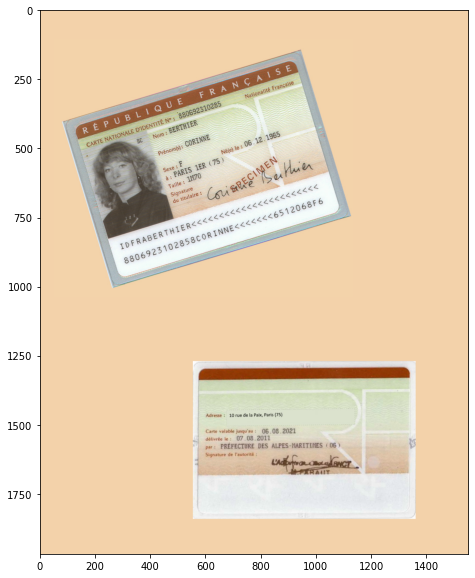

In [39]:
im = cv.imread('CI RetV.png')
plt.imshow(im)

## On passe en niveau de gris

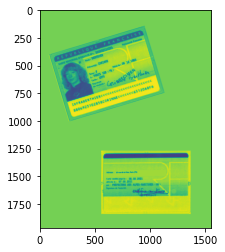

In [4]:
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(imgray)

## On utilise l'agorithme de détection de bords "Canny" (via OpenCV)

Au préalable on applique un flou gaussien (également connu sous le nom de lissage gaussien) qui donne le flou d'une image par une fonction gaussienne.

On applique ensuite un détecteur de bord Canny qui est un algorithme à plusieurs étages qui permet de détecter une large gamme de bords dans les images. Il a été développé par John F. Canny en 1986.

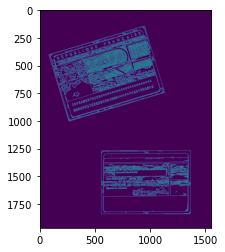

In [5]:
grayf = cv.GaussianBlur(imgray, (5, 5), 1)
edged = cv.Canny(grayf, 0, 50)
plt.imshow(edged)

## Détection de contours

Un seuillage avant :

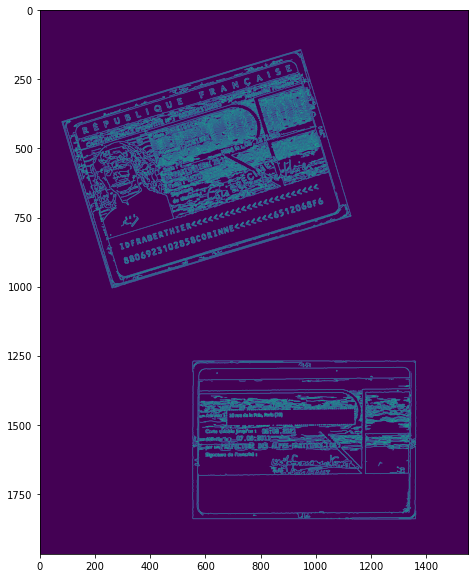

In [6]:
plt.rcParams['figure.figsize'] = [20, 10]
ret, thresh = cv.threshold(edged, 127, 255, 0)
plt.imshow(thresh)

In [7]:
#contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_NONE)
contours, hierarchy = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

In [8]:
contours = sorted(contours, key=cv.contourArea, reverse=True)

La détection de contours renvoit 2 objets:
* une liste (python) des points formant chaque contours
* un tableau des hiararchies de contours

Nombre de contours, nous en avons ici 1214 au total (cf. ci-dessous). Chaque élément de la liste contours contient un ensemble de points qui forme le polygone du contour :

In [9]:
len(contours)

1898

Le tableau hiérarchie est un tableau de 3 dimensions et a la forme suivante :  
`hierarchy[index][{0,1,2,3}] = { next contour (same level), 
                                previous contour (same level), 
                                child contour, 
                                parent contour}`  
-1 signifie pas de contour

In [10]:
hierarchy.shape

(1, 1898, 4)

On restreint les contours aux parents seulement

In [11]:
onlyParents = []
for i in range(hierarchy.shape[1]):
    if (hierarchy[0][i][3] < 0):
        onlyParents.append(contours[i])
len(onlyParents)

1898

In [12]:
im_target = im.copy()
x = cv.drawContours(im_target, onlyParents, -1, (0,255,0), 3)

Voici sur l'image les contours conservés.

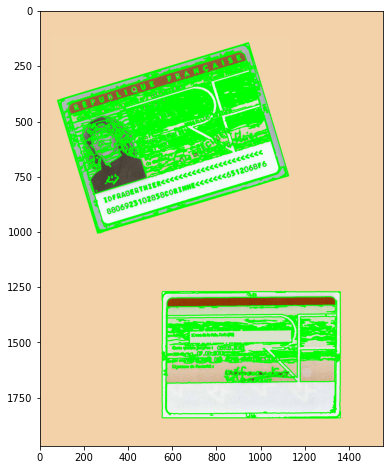

In [13]:
plt.rcParams['figure.figsize'] = [16, 8]
plt.imshow(im_target)

# On va découper la page (2 docs) via l'utilisation d'un algorithme de clustering (k-means)

In [14]:
import pandas as pd
from sklearn.cluster import KMeans

In [15]:
len(onlyParents)

1898

On met à plat les points:  
Certains polygones (contours) peuvent posséder plusieurs milliers de points, dans ce cas là on ne prendra que les 4 premiers points. On peut changer ce parametre en changemant la valeur de limit.

In [16]:
flatlist = []
limit = 3
for i in range(len(onlyParents)):
    if (len(onlyParents[i]) < 4):
        limit = len(onlyParents[i])
    for j in range(limit):
        flatlist.append(onlyParents[i][j])

In [17]:
len(flatlist)

4937

In [18]:
X = pd.DataFrame(columns=['X', 'Y'])
s = 0
for i in range(len(flatlist)):
        X.loc[s, 'X'] = flatlist[i][0][0]
        X.loc[s, 'Y'] = flatlist[i][0][1]
        s = s + 1

Entrainement du modèle KMeans non supervisé pour détecter et donc séparer les 2 clusters

In [19]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(n_clusters=2)

In [20]:
y = pd.DataFrame(kmeans.labels_)

## Nous avons séparé en deux cluster, maintenant nous allons prendre les coordonnées extremes de ces deux clusters

Par cluster on cherche 2 points (bord haut/gauche et bas/droite), ca revient a chercher
* La coordonnée la plus a gauche ainsi que la plus à droite (plus grand et plus petit x)
* La coordonnée la plus en haut ainsi que la plus basse (plus grand et plus petit y)

In [21]:
def getRectFromCluster(cluster):
    X0hg, Y0hg = 500000, 500000
    X0bd, Y0bd = 0, 0
    for index, point in X.iterrows():
        if (y.loc[index, 0]==cluster):
            # cluster 0
            if (X.loc[index, 'X'] < X0hg):
                X0hg = X.loc[index, 'X']
            elif (X.loc[index, 'X'] > X0bd):
                X0bd = X.loc[index, 'X']
            if (X.loc[index, 'Y'] < Y0hg):
                Y0hg = X.loc[index, 'Y']
            elif (X.loc[index, 'Y'] > Y0bd):
                Y0bd = X.loc[index, 'Y']
    return (int(X0hg), int(Y0hg)), (int(X0bd), int(Y0bd))

p01, p02 = getRectFromCluster(0)
p11, p12 = getRectFromCluster(1)

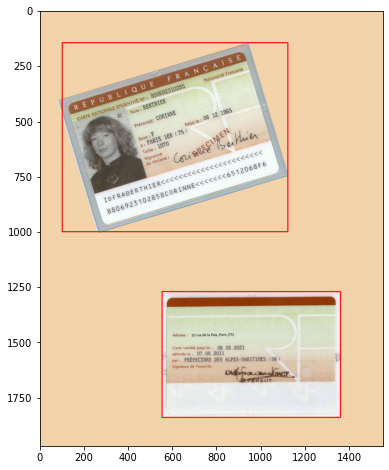

In [22]:
color = (255, 0, 0) 
thickness = 3
imgfinal = im.copy()
imgfinal = cv.rectangle(imgfinal, p01 , p02, color, thickness)
imgfinal = cv.rectangle(imgfinal, p11 , p12, color, thickness)
plt.imshow(imgfinal)

## On découpe les images récupérées

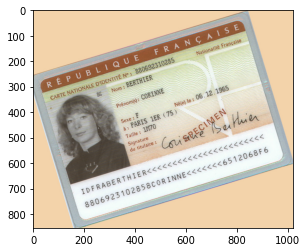

In [40]:
def cutImage (image, p_hg, p_bd):
    return image[p_hg[1]:p_bd[1], p_hg[0]:p_bd[0]]

plt.rcParams['figure.figsize'] = [8, 4]
plt.imshow(cutImage(im.copy(), p01, p02))

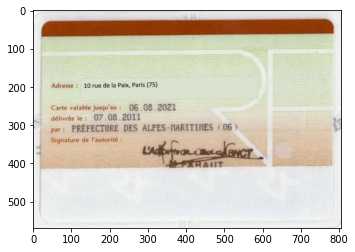

In [41]:
plt.imshow(cutImage(im.copy(), p11, p12))

## On sauvegarde les nouvelles images

In [42]:
cv.imwrite('C0.jpg', cutImage(im.copy(), p01, p02)) 
cv.imwrite('C1.jpg', cutImage(im.copy(), p11, p12)) 

True

# Et si on avait plus de 2 documents ?

In [26]:
kmeans = KMeans()
kmeans.fit(X)

KMeans()

In [27]:
y = pd.DataFrame(kmeans.labels_)
print("Max =", y.max()[0], " - Min =", y.min()[0])
ClusterMax = y.max()[0]

Max = 7  - Min = 0


In [33]:
p1 = [] # points Haut à gauche
p2 = [] # points Bas à droite
for i in range(ClusterMax+1):
    A, B = getRectFromCluster(i)
    p1.append(A)
    p2.append(B)
print("Nombre de clusters: ", ClusterMax+1)

Nombre de clusters:  8


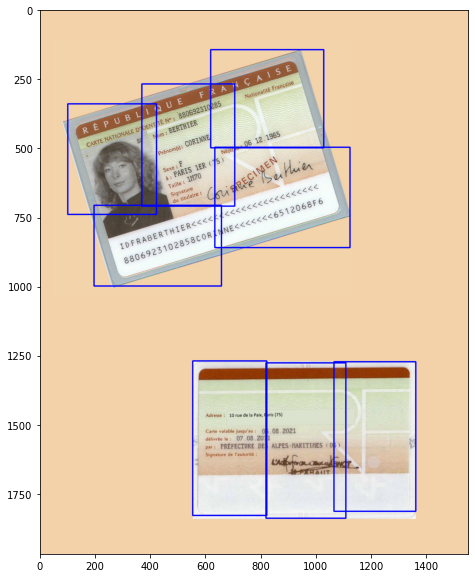

In [36]:
color = (0, 0, 255)
thickness = 3
imgfinal = im.copy()
for i in range(ClusterMax+1):
    imgfinal = cv.rectangle(imgfinal, p1[i] , p2[i], color, thickness)

plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(imgfinal)

On a 8 clusters au total mais on voit bien que l'on a 2 grands clusters qui "englobent les autres".  
Le problème est que la détection de cluster s'est effectuée comme un puzzle. Il n'y a pas deux rectangles qui incluent les autres mais un assemblage. Une méthode serait de diminuer le KMeans un par un ... Dés qu'on détecte une intersection entre deux rectangles : on relance le KMeans en réduisant le nombre de clusters en parametres de 1 : KMeans(n_clusters=n).

In [124]:
class Point: 
    def __init__(self, x, y): 
        self.x = x 
        self.y = y 
    def print_coord(self):
        print('Point ({},{})'.format(self.x, self.y))
        
class Rectangle:
    def __init__(self, l, r): 
        self.l = l 
        self.r = r 
        
    def print_coord(self):
        print('Rect TL({},{}) | Rect BR({},{})'.format(self.l.x, self.l.y, self.r.x, self.r.y))
    
    def getTopLeftPointCoord(self):
        return (self.l.x, self.l.y)
    
    def getBottomRightPointCoord(self):
        return (self.r.x, self.r.y)

    def getTopLeftPoint(self):
        return self.l
    
    def getBottomRightPoint(self):
        return self.r
    
rectangles = []
for i in range(ClusterMax+1):
    rectangles.append(Rectangle(Point(p1[i][0], p1[i][1]), Point(p2[i][0], p2[i][1])))
rectangles[0].print_coord()

Rect TL(195,706) | Rect BR(656,998)


Fonction qui détecte deux rectangles qui ont une intersection

True

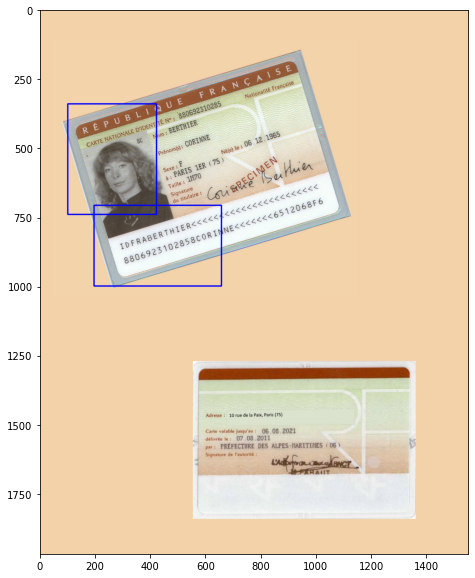

In [123]:
# Returns true if two rectangles(l1, r1) and (l2, r2) overlap 
def RectOverlap(R1, R2): 
    if(R1.getTopLeftPoint().x >= R2.getBottomRightPoint().x or R2.getTopLeftPoint().x >= R1.getBottomRightPoint().x): 
        return False
    if(R1.getTopLeftPoint().y >= R2.getBottomRightPoint().y or R2.getTopLeftPoint().y >= R1.getBottomRightPoint().y): 
        return False
    return True

i1 = 0
i2 = 3
test = im.copy()
test = cv.rectangle(test, rectangles[i1].getTopLeftPointCoord(), rectangles[i1].getBottomRightPointCoord(), color, thickness)
test = cv.rectangle(test, rectangles[i2].getTopLeftPointCoord(), rectangles[i2].getBottomRightPointCoord(), color, thickness)
plt.rcParams['figure.figsize'] = [20, 10]
plt.imshow(test)

RectOverlap(rectangles[i2], rectangles[i1])

In [125]:
def hasOverlap():
    for i in range(ClusterMax+1):
        for j in range(ClusterMax+1):
            if (RectOverlap(rectangles[i], rectangles[j])):
                return True
    return False
hasOverlap()

True

In [100]:
for i in range(ClusterMax+1):
    cv.imwrite('C' + str(i) + '.jpg', cutImage(im.copy(), p1[i] , p2[i]))